In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [115]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


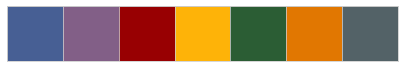

In [4]:
# import custom palette
import my_palette as mp

In [296]:
# read in actor dataset
actor_df = pd.read_json('../data_wrangling/capstone2_ref.json')

In [254]:
# observed DataFrame before aggregation
actor_df.head()

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
0,2,Mark Hamill,16121,The Big Red One,2.273880e+07,1.419948e+07,8.539315e+06,28.674100,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2,Mark Hamill,11,Star Wars,3.319102e+09,4.708566e+07,3.272016e+09,25.665140,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,Mark Hamill,14919,Batman: Mask of the Phantasm,9.944670e+06,1.062202e+07,-6.773465e+05,42.251381,0,1,...,0,0,0,0,1,0,0,1,0,0
3,2,Mark Hamill,1892,Return of the Jedi,1.490146e+09,8.417359e+07,1.405972e+09,31.663895,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,Mark Hamill,16220,Wizards,3.930685e+07,5.240914e+06,3.406594e+07,25.377660,0,4,...,1,0,0,0,0,0,1,0,0,0


 > **ORIGINAL TARGET**

In [7]:
def aggregate_data(data):
    """Return aggregated DataFrame grouped by each actor"""
    # aggregate while making counts of genres and taking the average of all other values
    agg_actor_df = data.groupby('person_id').agg(
        {'revenue': np.mean, 'budget': np.mean, 'age': np.mean, 'gender': 'first', 
         'order':np.mean, 'popularity':np.mean, 'release_date': np.mean, 
         'runtime': np.mean, 'usa': 'first', 'vote_average': np.mean, 
         'vote_count': np.mean, 'action': np.sum, 'adventure': np.sum, 
         'animation': np.sum, 'comedy': np.sum, 'crime': np.sum, 'drama': np.sum, 
         'family': np.sum, 'fantasy': np.sum, 'history': np.sum, 'horror': np.sum, 
         'music': np.sum, 'mystery': np.sum, 'romance': np.sum, 'science_fiction': np.sum, 
         'thriller': np.sum, 'war': np.sum, 'western': np.sum})
    
    return agg_actor_df

In [242]:
# aggregate over each actor and get DataFrame with unmodified target
df = aggregate_data(actor_df)
df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,1.032727e+09,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,4.376895e+08,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,7.803955e+08,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,1.147836e+09,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,1.471965e+09,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [100]:
# separate training data into features and target
X = df.drop('revenue', axis=1)
y = df['revenue']

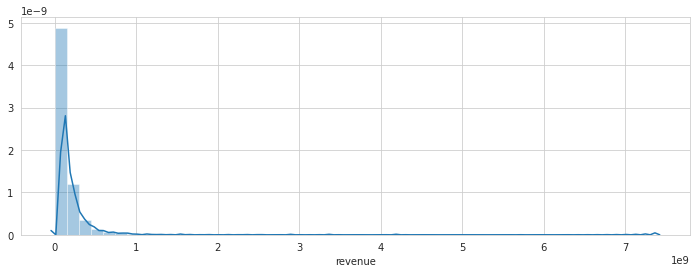

In [113]:
# plot target distribution
sns.distplot(y);

In [229]:
def scratch_cv(features, target, params, log, scaled, scaled_df):
    """Return average mean absolute error from 10 fold cross validation"""
    # create empty list to hold MAE from each fold
    mae_lst = []    
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)
    # split data into 10 folds
    for train_index, test_index in folds.split(features, target):
        train_features = features.iloc[train_index]
        train_target = target.iloc[train_index]
        test_features = features.iloc[test_index]
        test_target = target.iloc[test_index]
        # instantiate and fit model
        model = xgb.XGBRegressor(params=params, objective='reg:squarederror', 
                             random_state=27, n_jobs=-1).fit(train_features, train_target)
        # get predictions
        y_pred = model.predict(test_features)
        if log:
            # convert data from log dollars to dollars
            test_target = np.exp(test_target)
            y_pred = np.exp(y_pred)
        if scaled:
            # get column that was scaled
            y = scaled_df['revenue']
            # convert data from scaled dollars to dollars
            test_target = np.multiply(test_target, np.std(y)) + np.mean(y)
            y_pred = np.multiply(y_pred, np.std(y)) + np.mean(y)
        # calculate MAE for each fold and save results to list
        errors = np.absolute(y_pred - test_target)
        mae = np.mean(errors)
        mae_lst.append(mae)
        
    return mae_lst

In [228]:
def get_cv_mae(
    features, target, params={}, log=False, scaled=False, scaled_df=pd.DataFrame()):
    """Return average mean absolute error from 10 fold cross validation"""
    # get average result from each CV fold
    mae_lst = scratch_cv(features, target, params, log, scaled, scaled_df)
    # get overall average MAE
    average_mae = np.mean(mae_lst)
    # get MAE range over all 10 folds
    mae_range = (np.min(mae_lst), np.max(mae_lst))
        
    return f'Average MAE: ${average_mae:,.2f} \
    CV Range: (${mae_range[0]:,.2f}, ${mae_range[1]:,.2f})'

In [230]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(X, y)

'Average MAE: $56,776,498.90     CV Range: ($51,475,957.14, $61,623,961.37)'

 > **LOG TARGET**

In [295]:
def get_log_revenue(data):
    """Returns DataFrame with log of revenue"""
    copy_df = data.copy()
    copy_df['revenue'] = np.log(copy_df['revenue'])
    
    return copy_df

In [297]:
# aggregate over each actor and get DataFrame with log target
log_df = get_log_revenue(aggregate_data(actor_df))
log_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,20.755469,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,19.897020,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,20.475311,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,20.861144,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,21.109864,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [298]:
# separate training data into features and target
log_X = log_df.drop('revenue', axis=1)
log_y = log_df['revenue']

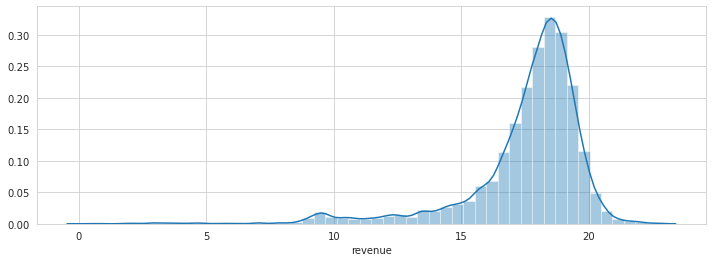

In [299]:
# plot target distribution
sns.distplot(log_y);

In [300]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(log_X, log_y, log=True)

'Average MAE: $58,845,682.77     CV Range: ($51,836,055.04, $64,859,952.92)'

 > **SCALED TARGET**

In [274]:
def scale_revenue(data):
    """Returns DataFrame with scaled revenue"""
    mean = np.mean(data['revenue'])
    std = np.std(data['revenue'])
    copy_df = data.copy()
    copy_df['revenue'] =  (copy_df['revenue'] - mean) / std
    
    return copy_df

In [239]:
# aggregate over each actor and get DataFrame with scaled target
scaled_df = scale_revenue(aggregate_data(actor_df))
scaled_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,3.139947,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,1.050176,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.253759,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,3.544210,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,4.682549,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [138]:
# separate training data into features and target
scaled_X = scaled_df.drop('revenue', axis=1)
scaled_y = scaled_df['revenue']

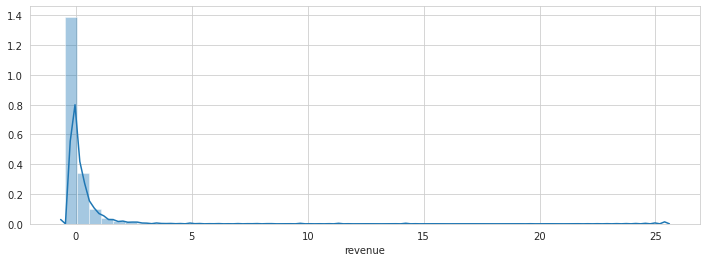

In [139]:
# plot target distribution
sns.distplot(scaled_y);

In [232]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(scaled_X, scaled_y, scaled=True, scaled_df=df)

'Average MAE: $56,754,119.36     CV Range: ($51,347,125.14, $61,414,104.66)'

 > **NO OUTLIERS TARGET**

In [164]:
def remove_outliers(data):
    mean = np.mean(data['revenue'])
    std = np.std(data['revenue'])
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    data = data[(data['revenue'] < upper) & (data['revenue'] > lower)]
    
    return data

In [246]:
# aggregate over each actor and get DataFrame with no outliers target
no_df = remove_outliers(aggregate_data(actor_df))
no_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,4.376895e+08,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,7.803955e+08,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,8.530622e+08,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,7.067063e+08,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,4.196991e+08,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0


In [167]:
# separate training data into features and target
no_X = no_df.drop('revenue', axis=1)
no_y = no_df['revenue']

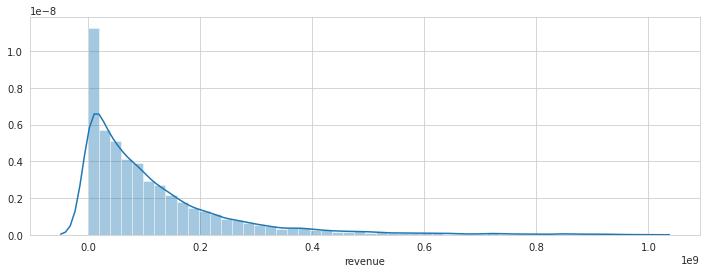

In [131]:
# plot target distribution
sns.distplot(no_y);

In [168]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(no_X, no_y)

'Average MAE: $47,905,287.92     CV Range: ($45,149,272.14, $51,617,642.87)'

In [169]:
# get count of observations dropped
df.shape[0] - no_df.shape[0]

110

In [171]:
# get DattaFrame of removed actors
removed_df = pd.concat([df, no_df]).drop_duplicates(keep=False)
removed_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,1.032727e+09,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
5,1.147836e+09,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,1.471965e+09,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0
14,1.212115e+09,1.732049e+08,51.864172,1,0.500000,26.636000,2009.500000,98.500000,1,7.400000,...,0,0,0,0,0,0,0,0,0,0
130,1.289036e+09,3.927029e+07,49.986653,0,5.750000,36.427000,1984.250000,112.000000,0,7.175000,...,1,0,0,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360281,1.145643e+09,1.543398e+08,31.272374,1,7.000000,43.330000,2019.000000,124.000000,0,7.000000,...,0,0,0,0,0,0,1,0,0,0
1414734,1.042716e+09,1.887902e+08,12.293202,0,0.000000,25.035000,2016.000000,106.000000,1,6.800000,...,1,0,0,0,0,0,0,0,0,0
1515478,1.055888e+09,1.844456e+08,27.677502,0,1.000000,72.770000,2019.000000,128.000000,0,7.100000,...,1,0,0,0,0,1,0,0,0,0


In [210]:
# get names of removed actors
actor_df[actor_df['person_id'].isin(removed_df.index)]['name'].unique()

array(['Mark Hamill', 'Peter Cushing', 'Anthony Daniels',
       'Ellen DeGeneres', 'Kenny Baker', 'Wolf Kahler',
       'Dominic Monaghan', 'Lee Arenberg', 'Thomas Mitchell',
       'Armelia McQueen', 'Bob Peck', 'Martin Ferrero', 'Roy Atwell',
       'Adriana Caselotti', 'Eddie Collins', 'Pinto Colvig',
       'Billy Gilbert', 'Ed Wynn', "Barbara O'Neil", 'Gloria Stuart',
       'Jeffrey Kramer', 'Chris Rebello', 'Jay Mello', 'Lee Fierro',
       'Olivia de Havilland', 'Shirley Eaton', 'Tania Mallet',
       'Claudine Auger', 'Luciana Paluzzi', 'Rik Van Nutter',
       'Molly Peters', 'Robert MacNaughton', 'K. C. Martel',
       'Haya Harareet', 'Vivien Leigh', 'Bonnie Wright', 'Clark Gable',
       'Leslie Howard', 'Evelyn Keyes', 'Ann Rutherford',
       'Hattie McDaniel', 'Cammie King', 'Jack MacGowran',
       'Frederick Worlock', 'David Frankham', 'Sebastian Cabot',
       'David Prowse', 'Peter Mayhew', 'Sebastian Shaw', 'Richard Haydn',
       'Don Barclay', 'Donnie Dunagan', 

 > **SCALED NO OUTLIERS TARGET**

In [247]:
# aggregate over each actor and get DataFrame with scaled version of no outliers target
scaled_no_df = scale_revenue(remove_outliers(aggregate_data(actor_df)))
scaled_no_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,2.242888,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,4.655214,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,5.166718,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,4.136512,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,2.116252,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,-0.837773,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,-0.835489,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,-0.835489,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [185]:
# separate training data into features and target
scaled_no_X = scaled_no_df.drop('revenue', axis=1)
scaled_no_y = scaled_no_df['revenue']

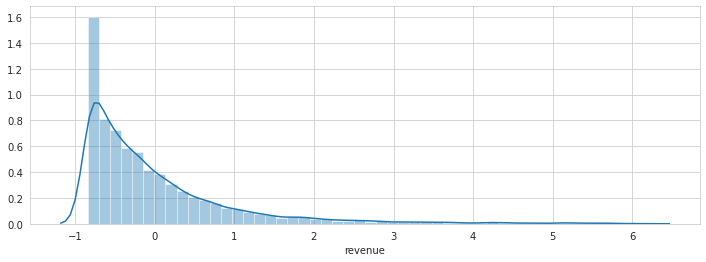

In [186]:
# plot target distribution
sns.distplot(scaled_no_y);

In [233]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(scaled_no_X, scaled_no_y, scaled=True, scaled_df=df)

'Average MAE: $95,732,571.44     CV Range: ($90,108,672.66, $103,190,005.93)'

 > **NO OUTLIERS SCALED TARGET**

In [248]:
# aggregate over each actor and get DataFrame with no outliers version of scaled target
no_scaled_df = remove_outliers(scale_revenue(aggregate_data(actor_df)))
no_scaled_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,1.050176,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.253759,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,2.508964,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,1.994963,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,0.986994,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,-0.486858,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,-0.485719,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,-0.485719,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [189]:
# separate training data into features and target
no_scaled_X = no_scaled_df.drop('revenue', axis=1)
no_scaled_y = no_scaled_df['revenue']

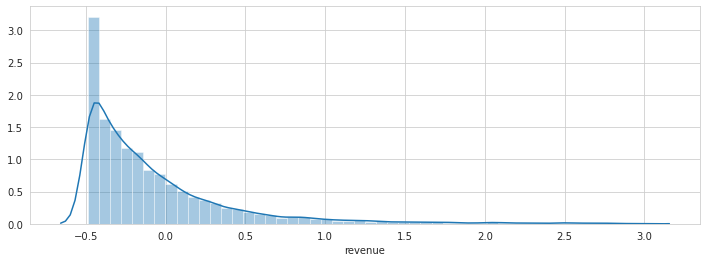

In [190]:
# plot target distribution
sns.distplot(no_scaled_y);

In [234]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(no_scaled_X, no_scaled_y, scaled=True, scaled_df=df)

'Average MAE: $47,889,094.44     CV Range: ($44,956,504.23, $51,511,543.42)'

 > **LOG MOVIES**

In [301]:
# get DataFrame with log movies, then aggregate over each actor
log_movies_df = aggregate_data(get_log_revenue(actor_df))
log_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,19.188312,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,18.885104,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,18.370769,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,19.260451,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,20.752725,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [302]:
# separate training data into features and target
log_movies_X = log_movies_df.drop('revenue', axis=1)
log_movies_y = log_movies_df['revenue']

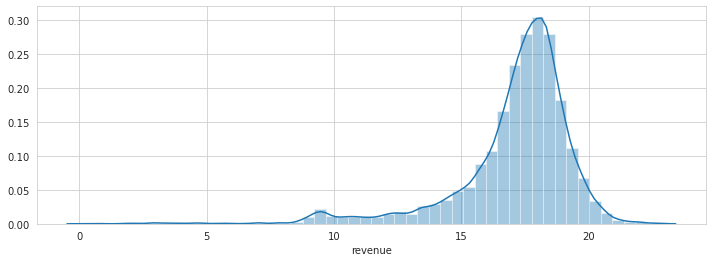

In [303]:
# plot target distribution
sns.distplot(log_movies_y);

In [304]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(log_movies_X, log_movies_y, log=True)

'Average MAE: $52,734,112.46     CV Range: ($44,606,950.44, $58,895,669.70)'

 > **NO OUTLIERS MOVIES**

In [249]:
# aggregate over each actor after removing outlier movies and get DataFrame
no_movies_df = aggregate_data(remove_outliers(actor_df))
no_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,2.425752e+07,8.778750e+06,45.773425,0,1.400000,13.497800,1997.000000,86.200000,1,6.620000,...,1,0,1,0,1,0,1,1,1,0
3,2.299171e+08,8.345003e+07,56.479322,0,0.783784,22.042243,1998.540541,118.027027,1,6.562162,...,1,1,1,0,5,9,4,17,2,2
4,5.191338e+07,2.402895e+07,38.717047,1,4.000000,8.555667,1995.111111,102.000000,1,6.044444,...,1,0,1,1,0,4,0,1,0,0
5,6.220332e+07,1.244080e+07,57.560388,0,1.000000,10.428500,1970.500000,86.000000,0,7.000000,...,0,0,1,0,0,0,1,0,0,0
6,1.166933e+08,1.531840e+07,32.731678,0,8.000000,11.983000,1978.000000,132.000000,0,6.500000,...,1,0,0,0,0,0,0,0,0,0


In [214]:
# separate training data into features and target
no_movies_X = no_movies_df.drop('revenue', axis=1)
no_movies_y = no_movies_df['revenue']

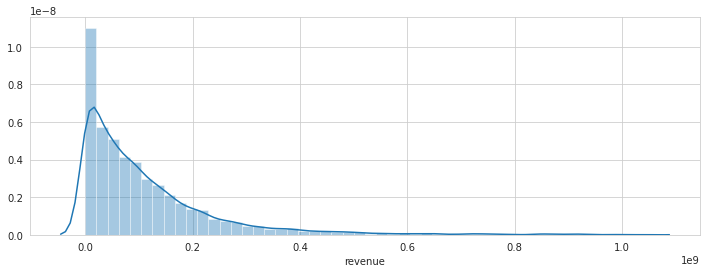

In [219]:
# plot target distribution
sns.distplot(no_movies_y);

In [217]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(no_movies_X, no_movies_y)

'Average MAE: $45,345,984.88     CV Range: ($43,233,277.09, $47,633,061.81)'

 > **SCALED MOVIES**

In [278]:
# aggregate over each actor after removing outlier movies and get DataFrame
scaled_movies_df = aggregate_data(scale_revenue(actor_df))
scaled_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,2.931757,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,0.933193,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.084246,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,3.318376,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,4.407034,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [279]:
# separate training data into features and target
scaled_movies_X = scaled_movies_df.drop('revenue', axis=1)
scaled_movies_y = scaled_movies_df['revenue']

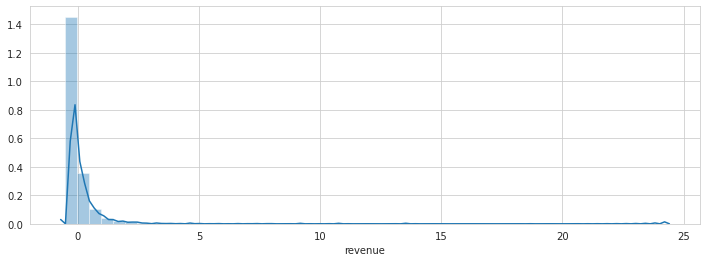

In [280]:
# plot target distribution
sns.distplot(scaled_movies_y);

In [281]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(scaled_movies_X, scaled_movies_y, scaled=True, scaled_df=actor_df)

'Average MAE: $56,882,152.92     CV Range: ($51,471,032.99, $62,011,339.70)'

 > **NO OUTLIERS SCALED MOVIES**

In [282]:
# get DataFrame with no outliers version of scaled movies, then aggregate over each actor
no_scaled_movies_df = aggregate_data(remove_outliers(scale_revenue(actor_df)))
no_scaled_movies_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,-0.455408,8.778750e+06,45.773425,0,1.400000,13.497800,1997.000000,86.200000,1,6.620000,...,1,0,1,0,1,0,1,1,1,0
3,0.235344,8.345003e+07,56.479322,0,0.783784,22.042243,1998.540541,118.027027,1,6.562162,...,1,1,1,0,5,9,4,17,2,2
4,-0.362520,2.402895e+07,38.717047,1,4.000000,8.555667,1995.111111,102.000000,1,6.044444,...,1,0,1,1,0,4,0,1,0,0
5,-0.327959,1.244080e+07,57.560388,0,1.000000,10.428500,1970.500000,86.000000,0,7.000000,...,0,0,1,0,0,0,1,0,0,0
6,-0.144942,1.531840e+07,32.731678,0,8.000000,11.983000,1978.000000,132.000000,0,6.500000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,-0.536759,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,-0.535669,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,-0.535669,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [283]:
# separate training data into features and target
no_scaled_movies_X = no_scaled_movies_df.drop('revenue', axis=1)
no_scaled_movies_y = no_scaled_movies_df['revenue']

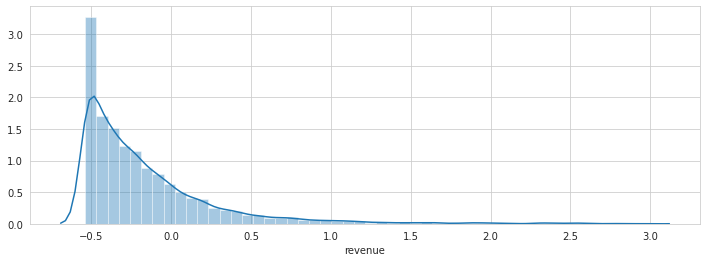

In [284]:
# plot target distribution
sns.distplot(no_scaled_movies_y);

In [285]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae(no_scaled_movies_X, no_scaled_movies_y, scaled=True, scaled_df=actor_df)

'Average MAE: $45,396,230.97     CV Range: ($43,633,931.55, $47,863,360.60)'